In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Fundamental classes
import numpy as np
import pandas as pd
import tensorflow as tf
import os

# Image related
import cv2
from PIL import Image

# For ploting
import matplotlib.pyplot as plt

# For the model and it's training
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, BatchNormalization, GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from tensorflow.python.client import device_lib

In [ ]:
# Setting variables for later use
data = []
labels = []
classes = 43
cur_path = '/content/drive/My Drive/Traffic sign recognition/GTSRB/Train'  # Update to your Google Drive path

# Retrieving the images and their labels
for i in range(classes):
    path = os.path.join(cur_path, str(i))  # Path to each class folder
    images = os.listdir(path)  # List all images in the class folder

    for a in images:
        try:
            image = Image.open(os.path.join(path, a))  # Open each image
            image = image.resize((30,30))  # Resize image to 30x30 pixels
            image = np.array(image)  # Convert image to a NumPy array
            data.append(image)  # Append the image data to the data list
            labels.append(i)  # Append the class label to the labels list
        except Exception as e:
            print(f"Error loading image {a}: {e}")

# Converting lists into numpy arrays
data = np.array(data)
labels = np.array(labels)

print(f"Data shape: {data.shape}, Labels shape: {labels.shape}")


In [ ]:
# Checking data shape
print(f"Data shape: {data.shape}, Labels shape: {labels.shape}")

# Normalize image data
data = data / 255.0  # Normalize the pixel values to the range [0, 1]

# Splitting training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Displaying the shape after the split
print(f"Train data shape: {X_train.shape}, Test data shape: {X_test.shape}")
print(f"Train labels shape: {y_train.shape}, Test labels shape: {y_test.shape}")

# Function to one-hot encode labels
def one_hot_encode(labels, num_classes):
    return to_categorical(labels, num_classes)

# Converting the labels into one hot encoding
y_train = one_hot_encode(y_train, 43)
y_test = one_hot_encode(y_test, 43)

# Displaying the shape after one-hot encoding
print(f"One-hot encoded train labels shape: {y_train.shape}, One-hot encoded test labels shape: {y_test.shape}")

Data shape: (39209, 30, 30, 3), Labels shape: (39209,)
Train data shape: (31367, 30, 30, 3), Test data shape: (7842, 30, 30, 3)
Train labels shape: (31367,), Test labels shape: (7842,)
One-hot encoded train labels shape: (31367, 43), One-hot encoded test labels shape: (7842, 43)


In [ ]:
# Build the model
model = Sequential()

# First conv block with BatchNormalization
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:], kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

# Second conv block with BatchNormalization
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

# Global Average Pooling instead of Flatten
model.add(GlobalAveragePooling2D())

# Fully connected layers with dropout
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(rate=0.3))

# Output layer
model.add(Dense(43, activation='softmax'))

# Compile the model using Stochastic Gradient Descent (SGD)
optimizer = SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Model summary
model.summary()

# Stochastic Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,       # Random rotations between -15° and +15°
    zoom_range=0.2,          # Random zooming between 80% and 120%
    width_shift_range=0.1,   # Random horizontal shifts (10% of total width)
    height_shift_range=0.1,  # Random vertical shifts (10% of total height)
    shear_range=0.1,         # Random shearing
    horizontal_flip=True,    # Randomly flip images horizontally
    vertical_flip=False      # Vertical flipping if needed
)
datagen.fit(X_train)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 26, 26, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 22, 22, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 22, 22, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 11, 11, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 11, 11, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 9, 9, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 9, 9, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 7, 7, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 7, 7, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 43)                  │          11,051 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 111,947 (437.29 KB)

 Trainable params: 111,563 (435.79 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
# Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001, verbose=1)

# Optionally stop training early if validation accuracy stops improving
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)

In [ ]:
history = model.fit(X_train, y_train, batch_size=32, epochs=20,
                    validation_data=(X_test, y_test),
                    callbacks=[reduce_lr, early_stopping])

Epoch 1/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.5200 - loss: 1.9848 - val_accuracy: 0.9751 - val_loss: 0.3645 - learning_rate: 0.0010
Epoch 2/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9570 - loss: 0.4022 - val_accuracy: 0.9685 - val_loss: 0.3226 - learning_rate: 0.0010
Epoch 3/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9765 - loss: 0.2971 - val_accuracy: 0.9865 - val_loss: 0.2369 - learning_rate: 0.0010
Epoch 4/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9818 - loss: 0.2514 - val_accuracy: 0.9806 - val_loss: 0.2402 - learning_rate: 0.0010
Epoch 5/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9831 - loss: 0.2306 - val_accuracy: 0.9938 - val_loss: 0.1945 - learning_rate: 0.0010
Epoch 6/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9835 - loss: 0.2249 - val_accuracy: 0.9596 - val_loss: 0.2753 - learning_rate: 0.0010
Epoch 7/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9786 - loss: 0.2302 

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9990 - loss: 0.0986
Test Loss: 0.09999438375234604
Test Accuracy: 0.9984697699546814


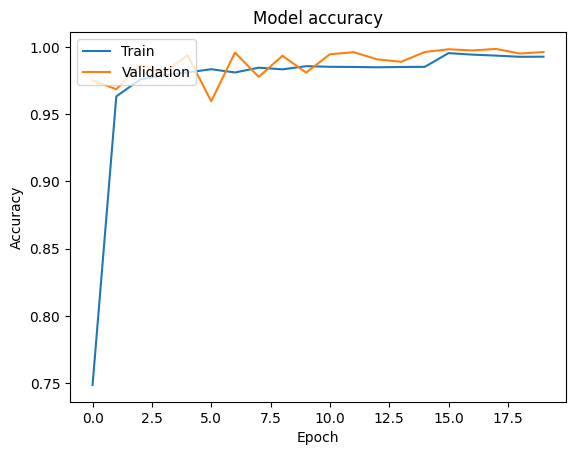

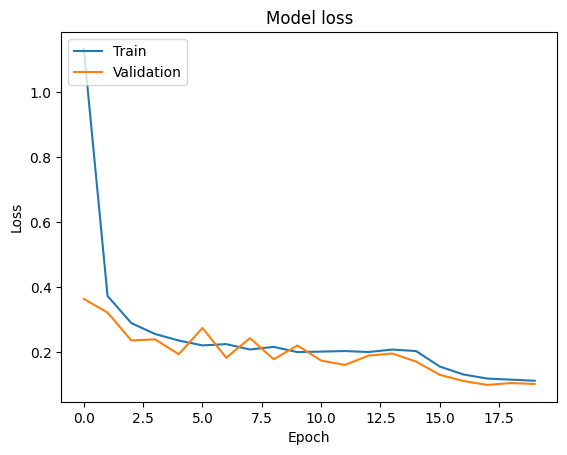

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model.save('traffic_sign_model.h5')

In [ ]:
model.save('/content/drive/My Drive/Traffic sign recognition/GTSRB/my_model.keras')

In [ ]:
model.save('/content/drive/My Drive/Traffic sign recognition/GTSRB/my_model.h5')